<a href="https://colab.research.google.com/github/elliekim9881/study_kaggle/blob/main/Titanic_Top_4_with_ensemble_modeling/Titanic_Top_4_with_ensemble_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic Top 4% with ensemble modeling

## 1. Introduction
- This script follows three main parts:
  - Feature analysis
  - Feature engineering
  - Modeling

In [1]:
from seaborn.rcmod import palettes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedGroupKFold, learning_curve, StratifiedKFold

sns.set(style='white', context='notebook', palette='deep')

## 2. Load and check data

### 2.1 Load data

In [2]:
# Load data
#### load train and test set

train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
IDtest = test["PassengerId"]

### 2.2 Outlier detection

In [3]:
def detect_outliers(df,n,features):
  # 데이터프레임df의 features가져와서 n 개 이상의 이상치를 포함하는 관측값에 해당하는 인덱스 목록 반환
  outlier_indices = []

  #col
  for col in features:
    #1st(25%)
    Q1 = np.percentile(df[col], 25)
    #3rd(75%)
    Q3 = np.percentile(df[col], 75)
    #IQR
    IQR = Q3 - Q1

    outlier_step = 1.5 * IQR

    #Determine a list of indices of outliers for feature col
    outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index

    #append the found outlier indices for col to the list of outlier indices
    outlier_indices.extend(outlier_list_col)

    # select observations containing more than 2 outliers
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list( k for k, v in outlier_indices.items() if v > n)

  return multiple_outliers

# detect ouliters from Age SiSp Parch and Fare

Outliers_to_drop = detect_outliers(train, 2, ['Age','SibSp', 'Parch','Fare'])


- 회귀문제의 경우 이상치가 예측에 큰 영향을 미칠 수 있으므로 관리
- IQR을 사용하여 이상치를 감지했고 이상치는 IQR을 벗어나는 값을 가진 행이다
- 숫자 값을 가진 features에서 이상치를 확인하기로 결정하였고 그런 이상치가 두개 이상 있는 행을 이상치로 간주했다.

In [4]:
train.loc[Outliers_to_drop] #show the outliers rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


- 10개의 outliers. 28, 89,342 티켓값/ 나머지는 SibSp의 값이 높다

In [5]:
# Drop outliers

train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

### 2.3 joining train and test set

In [6]:
#join train and test datasets in order to obtain the same number of features during categorical conversion

train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

### 2.4 check for null and missing values

In [7]:
# fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

#check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

- Age and Cabin features have an important part of missing values.
- survived의 결측치는 test에 survived 없기 때문


In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 3. Feature analysis

### 3.1 Numerical values


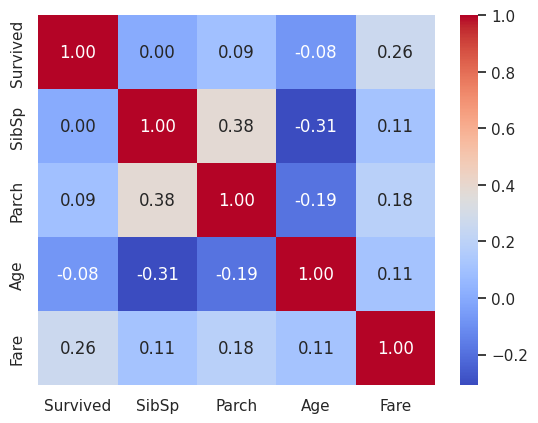

In [12]:
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True,fmt=".2f", cmap='coolwarm')

- Only fare feature seems to have a significative correlation with the survival probability.
- It doesn'mean that the other features are not usefull. Subpopulations in these fatrues can be correlated with the survival. To determine this, we need th explore in detail these features.


#### SibSP

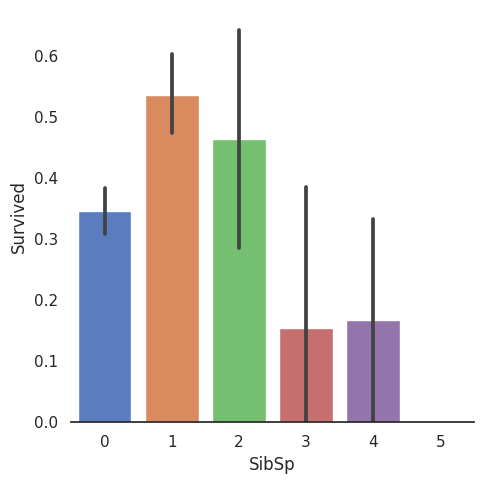

In [13]:
g = sns.catplot(x="SibSp",y="Survived", data=train, kind="bar", palette = "muted")
g.despine(left=True)

- 형제자매 배우자가 많은 승객은 생존 확률이 낮다.
- 싱글, 1명 2명과 함께 탄 승객은 생존확률이 더 높다.
- see feature engineering

#### Parch

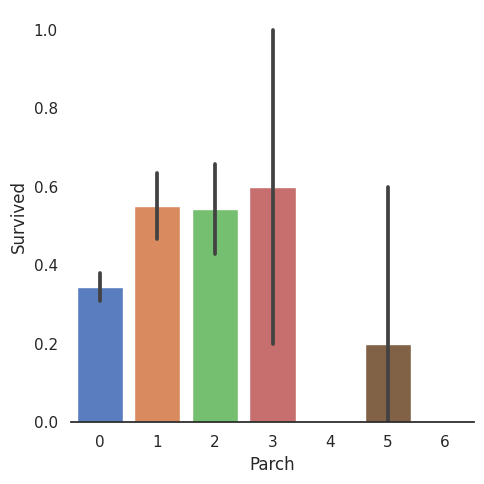

In [14]:
g = sns.catplot(x="Parch",y="Survived", data=train, kind="bar", palette = "muted")
g.despine(left=True)

- 가족의 수가 작은 경우가 싱글인 경우, 가족이 3-4명,5명 이상인 경우보다 더 많이 살았다.
- 부모/자녀가 3명인 승객의 생존율에 중요한 표준편차 존재

### Age

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)


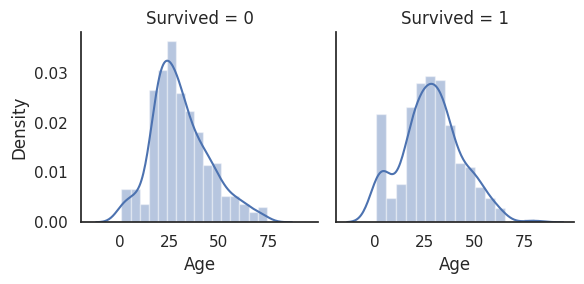

In [15]:
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.distplot, "Age")

 - Age distivution semms to be a tailed distribution, maybe a gaussian distribution.
 - We notice that age distribions are not the same in the survivied and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived.


<ipython-input-16-74148bcd47d6>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived']== 0 ) & (train['Age'].notnull())], color='Red', shade=True)
<ipython-input-16-74148bcd47d6>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  g = sns.kdeplot(train['Age'][(train['Survived']== 1 ) & (train['Age'].notnull())], color='Blue', shade=True)


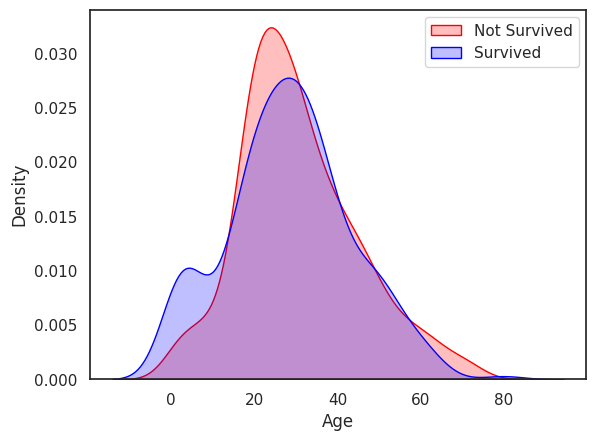

In [16]:
g = sns.kdeplot(train['Age'][(train['Survived']== 0 ) & (train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']== 1 ) & (train['Age'].notnull())], color='Blue', shade=True)
g = g.legend(["Not Survived", "Survived"])

- When we superimpose the two densities, we cleary see a peak correponsing(between 0 and 5) to babies and very young childrens.

#### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

<ipython-input-19-ac639836effd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %2f'%(dataset["Fare"].skew()))


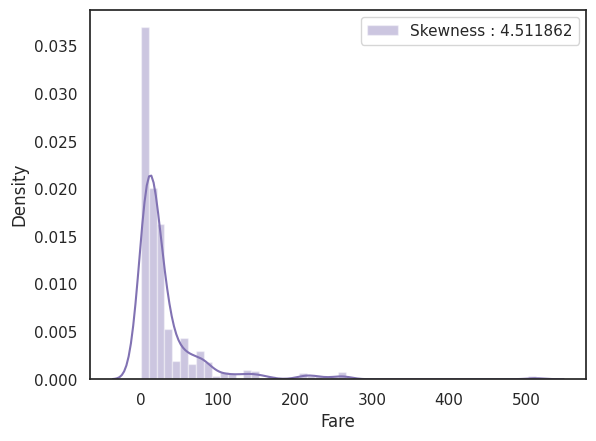

In [19]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %2f'%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 요금분포 치우쳐져있음, 로그 취해서 왜곡 줄여줌


In [20]:
dataset['Fare'] = dataset['Fare'].map(lambda i : np.log(i) if i > 0 else 0)

<ipython-input-21-ac639836effd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %2f'%(dataset["Fare"].skew()))


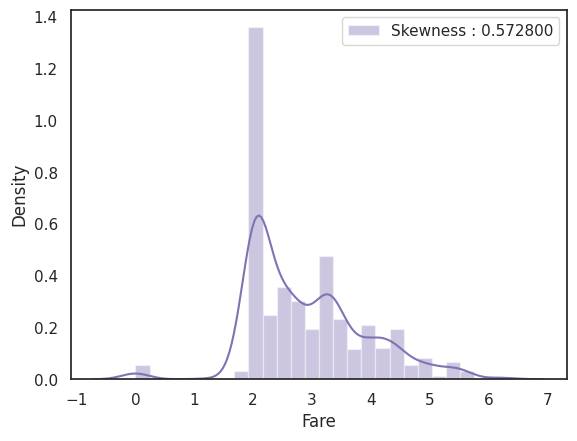

In [21]:
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %2f'%(dataset["Fare"].skew()))
g = g.legend(loc="best")

- 로그 변환 후 Skewness  줄어들었음

### 3.2 Cateforical values
#### Sex

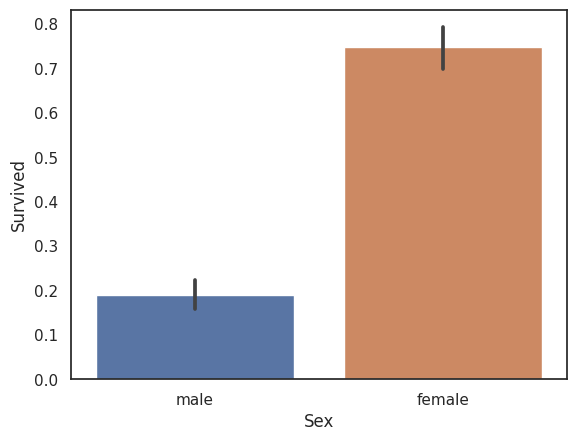

In [22]:
g = sns.barplot(x='Sex',y="Survived", data = train)

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 여성의 생존비율이 더 높은 것 확인 가능.

#### Pclass

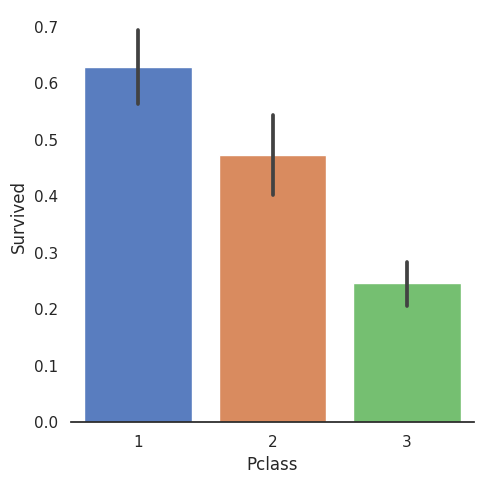

In [24]:
g = sns.catplot(x="Pclass",y="Survived", data=train, kind="bar", palette = "muted")
g.despine(left=True)

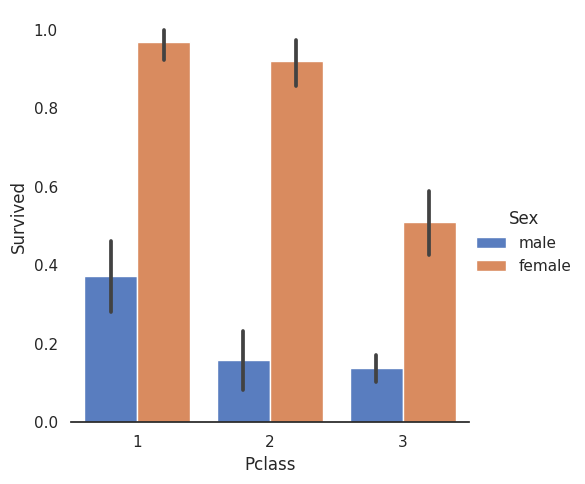

In [25]:
g = sns.catplot(x="Pclass",y="Survived", data=train, hue="Sex",kind="bar", palette = "muted")
g.despine(left=True)

- The passenger survival is not the smae in 3 classes. First class passengers have more chance to survive than second class and third class passengers.
- This trend is conserved when we look at both male and female passengers.

#### Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
# fill nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

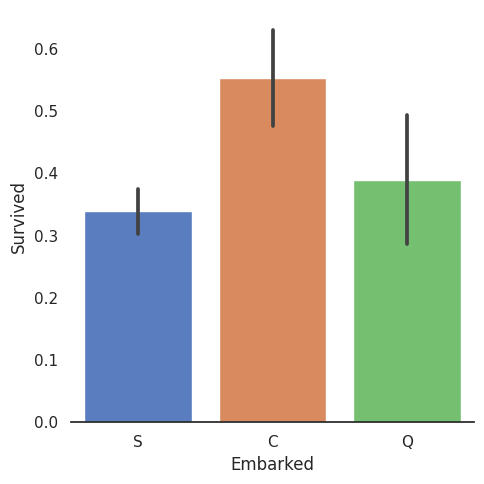

In [28]:
g = sns.catplot(x="Embarked",y="Survived", data=train, kind="bar", palette = "muted")
g.despine(left=True)

- It seems that passenger coming from Cherbourg (c) have more chance to survive.
- My hypothesis is that the proportion of first class passengers is higher for those who came from Cherbourg than Queenstown (Q), Southampton (S).
- Let's see the Pclass distribution vs Embarked

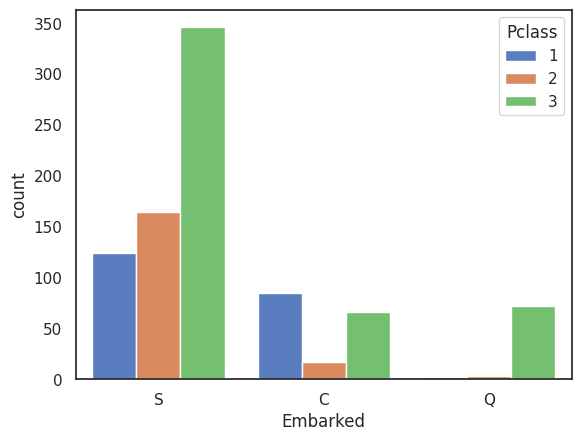

In [29]:
g = sns.countplot(data=train, x="Embarked", hue="Pclass", palette="muted")

- Indeed, the third class is the most frequent for passenger coming from Southampton (S) and Queenstown (Q), whereas Cherbourg passengers are mostly in first class which have the highest survival rate.

- At this point, i can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.

## 4.Filling missing Values

#### 4.1 Age
- As we see, Age column contains 256 missing values in the whole dataset.

- Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

- To adress this problem, i looked at the most correlated features with Age (Sex, Parch , Pclass and SibSP).

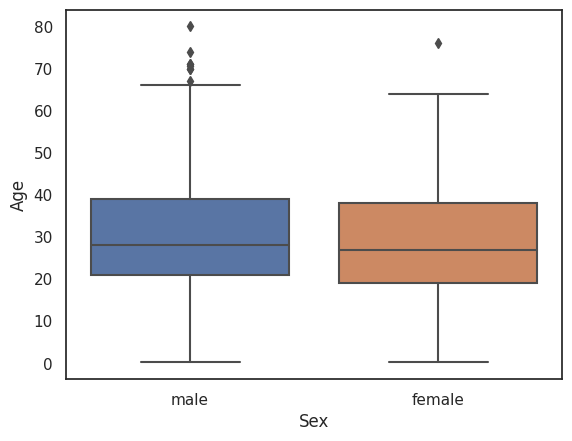

In [30]:
g = sns.boxplot(y='Age',x='Sex',data=dataset)

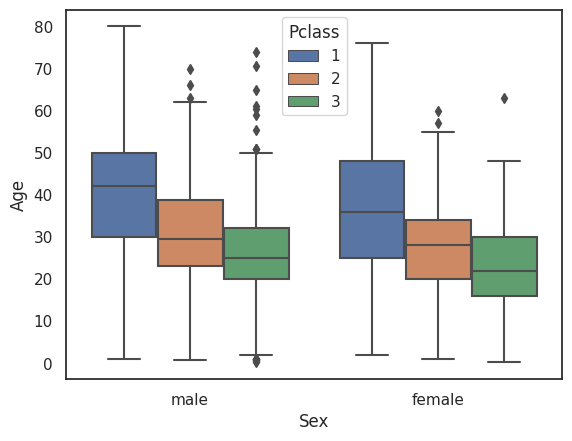

In [31]:
g = sns.boxplot(y='Age',x='Sex', hue='Pclass',data=dataset)

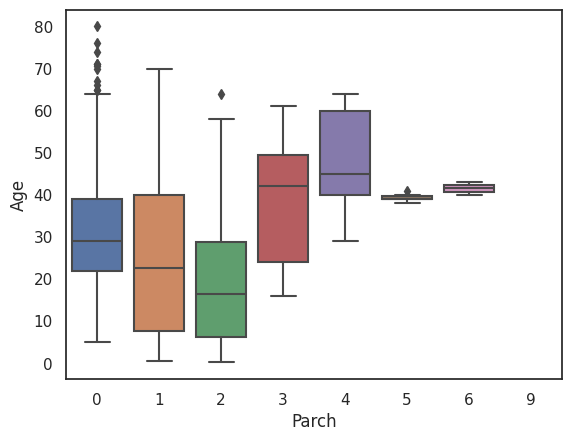

In [32]:
g = sns.boxplot(y='Age',x='Parch',data=dataset)

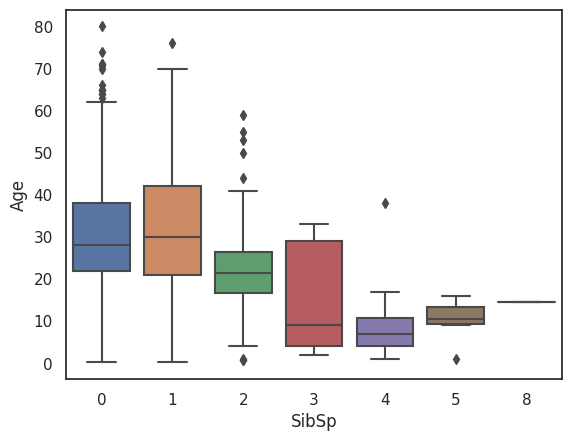

In [33]:
g = sns.boxplot(y='Age',x='SibSp',data=dataset)

- Age distribution seems to be the same in Male and Female subpopulations, so Sex is not informative to predict Age.

- However, 1rst class passengers are older than 2nd class passengers who are also older than 3rd class passengers.

- Moreover, the more a passenger has parents/children the older he is and the more a passenger has siblings/spouses the younger he is.

In [34]:
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

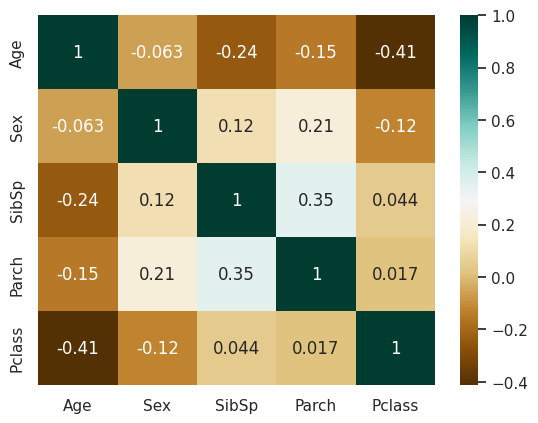

In [35]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap='BrBG', annot=True)

- parch의 함수에 따른 age플롯에서 부모/자녀의 수에 따라 Age 증가. 누락된 나이를 대입하기 위하여 sibib, parch, pclass사용.


In [36]:
# fill missing value of age

# fill age with the median age of similar rows according to pclass, parch and sibsp

index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()

  if not np.isnan(age_pred):
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med


<ipython-input-36-f02809bc676f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-36-f02809bc676f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-36-f02809bc676f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Age'].iloc[i] = age_pred
<ipython-input-36-f02809bc676f>:12: SettingWithCopyWarning: 
A value is trying to be set on

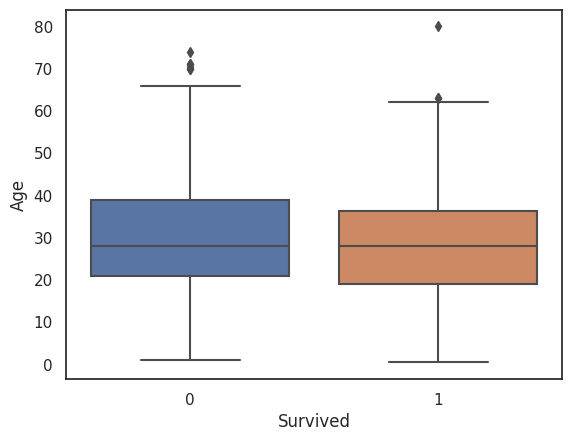

In [37]:
g = sns.boxplot(y='Age',x='Survived',data=train)

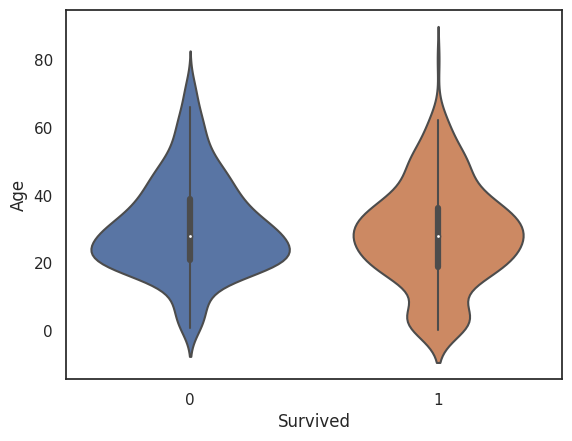

In [38]:
g1 = sns.violinplot(y='Age',x='Survived',data=train)

- No difference between median value of age in survived and not survived subpopulation.

- But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.



## 5. Feature engineering

#### 5.1 Name/Title


In [39]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- The Name feature contains information on passenger's title.

- Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model. 직함추가

In [40]:
#get title from name

dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

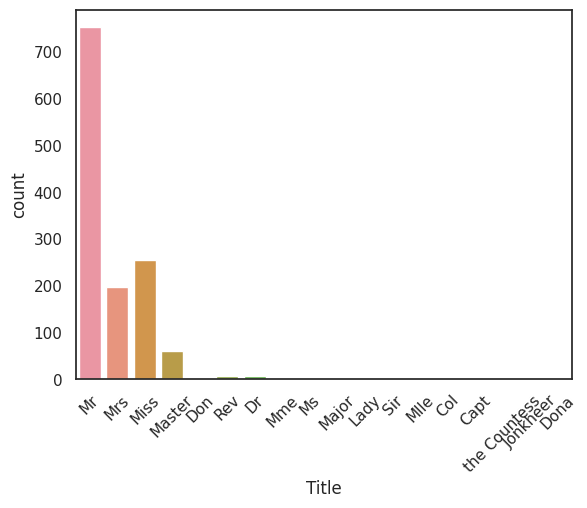

In [41]:
g = sns.countplot(x='Title',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

- There is 17titles in the dataset, most of them are very rare and we can group them in 4 categories.

In [42]:
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

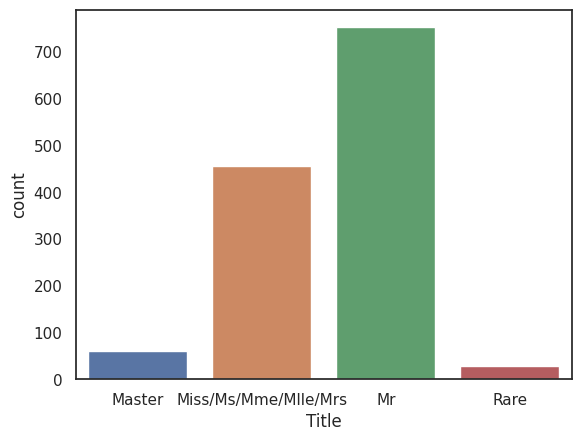

In [43]:
g = sns.countplot(data=dataset, x='Title')

x_labels = ["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"]
g.set_xticklabels(x_labels)

plt.show()

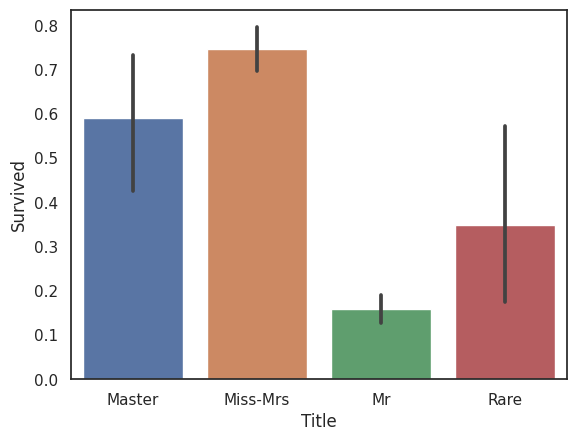

In [44]:
g = sns.barplot(x="Title",y="Survived",data=dataset)
g = g.set_xticklabels(["Master","Miss-Mrs","Mr","Rare"])

- woman and children first


In [45]:
dataset.drop(labels = ['Name'], axis=1, inplace=True)

#### 5.2 Family size
- We can imagine that large families will have more difficulties to evacuate, looking for theirs sisters/brothers/parents during the evacuation. So, i choosed to create a "Fize" (family size) feature which is the sum of SibSp , Parch and 1 (including the passenger).

In [46]:
# create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.10/dist-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1560: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


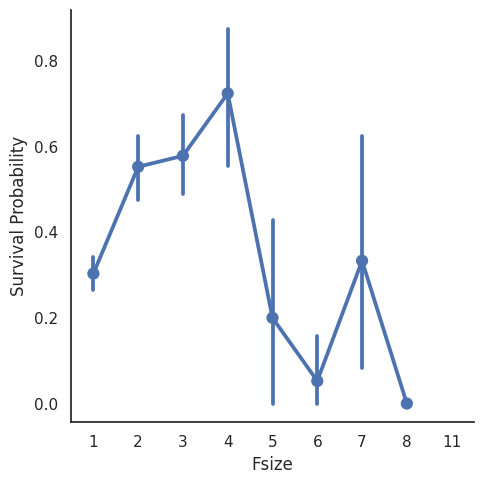

In [47]:
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind='point')
g = g.set_ylabels("Survival Probability")

- The family size seems to play an important role, survival probability is worst for large families.

- Additionally, i decided to created 4 categories of family size.

In [48]:
# create new feature of family size

dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

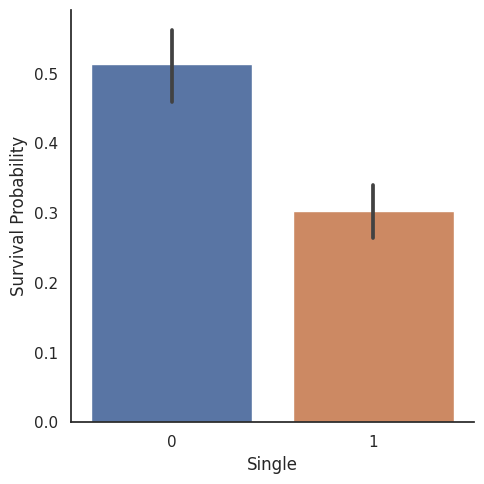

In [49]:
g = sns.catplot(x='Single', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels("Survival Probability")

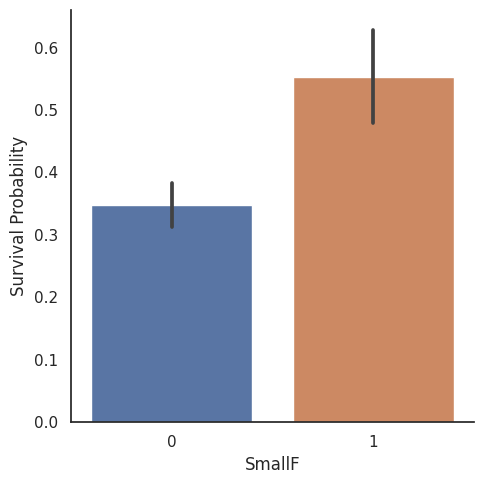

In [50]:
g = sns.catplot(x='SmallF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels("Survival Probability")

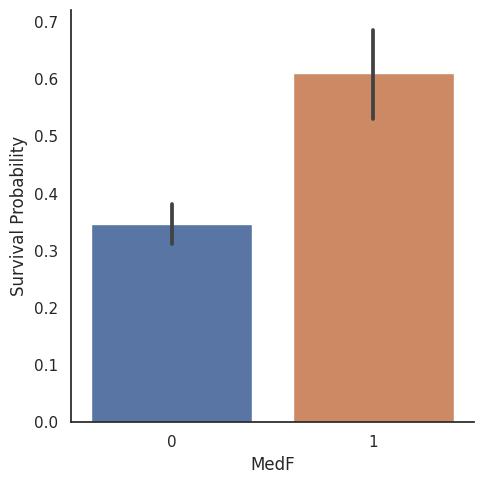

In [51]:
g = sns.catplot(x='MedF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels("Survival Probability")

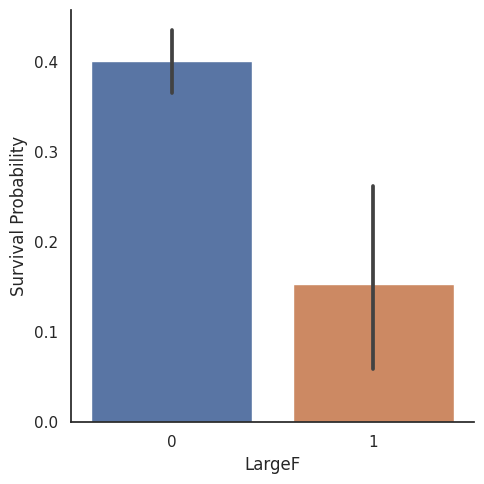

In [52]:
g = sns.catplot(x='LargeF', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels("Survival Probability")

- Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.

In [53]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix='Em')

In [54]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


- At this stage, we have 22 features.


#### 5.3 Cabin

In [55]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [56]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [57]:
dataset['Cabin'].isnull().sum()

1007

- The Cabin feature column contains 292 values and 1007 missing values.

- I supposed that passengers without a cabin have a missing value displayed instead of the cabin number.

In [58]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [59]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

- The first letter of the cabin indicates the Desk, i choosed to keep this information only, since it indicates the probable location of the passenger in the Titanic.

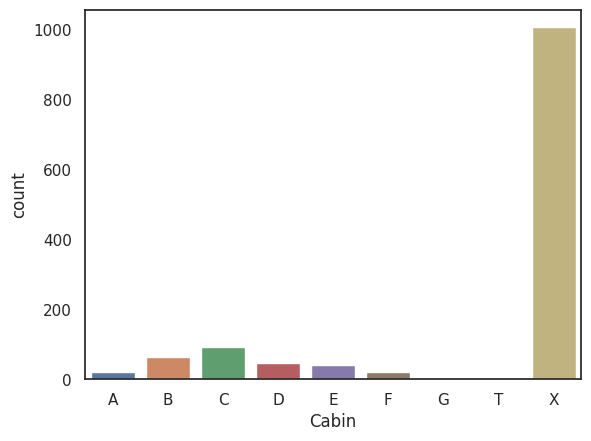

In [60]:
g = sns.countplot(data=dataset, x="Cabin", order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

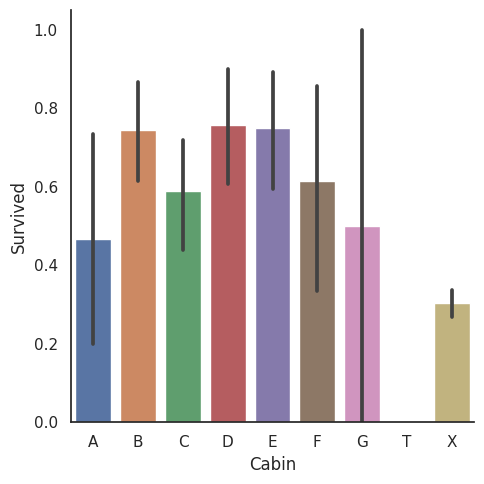

In [61]:
g = sns.catplot(y='Survived', x='Cabin', data=dataset,kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

-  선실을 가진 승객 수가 적기때문에 생존 확률은 중요한 표준 편차를 가지고 다른 좌석에 앉은 승객의 생존 확률을 구분할 수 있다.
- 일반적으로 객실이 있는 승객이 그렇지 않은 승객보다 생존 확률이 높은 것 확인 가능
- B,C,D,E,R좌석의 경우 더욱 그렇다.

In [62]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

#### 5.4 Ticket


In [63]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

- 이는 동일한 접두사를 공유하는 Ticket 함께 배치된 객실에 대해 예약될 수 있음을 의미할 수 있습니다. 따라서 선박 내 실제 객실 배치로 이어질 수 있습니다.

- 접두사가 같은 Ticket 클래스 및 생존율이 비슷할 수 있습니다.

- 그래서 Ticket feature 열을 Ticket 접두사로 대체하기로 결정했습니다. 더 많은 정보를 얻을 수 있습니다.

In [64]:
## Treat Ticket by extracting the ticket prefix. when there is no prefix if returns X.

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace(".","").replace('/',"").strip().split(' ')[0]) # take prefix
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [65]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [66]:
#Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'], prefix='Pc')

In [67]:
dataset.drop(labels=['PassengerId'], axis=1, inplace=True)

In [68]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## 6. Modeling

In [69]:
## separate train and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'], axis=1,inplace=True)

<ipython-input-69-fadfae26212a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=['Survived'], axis=1,inplace=True)


In [70]:
## separate train features and label

train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis=1)

<ipython-input-70-33da59c7645b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Survived'] = train['Survived'].astype(int)


#### 6.1 Simple modeling

##### 6.1.1 Cross validate models
- 10개의 인기 분류기를 비교하고 계층화된 kfold 교차 검증 절차를 통해 각 분류기의 평균 정확도를 평가
  - SVC
  - Decision Tree
  - AdaBoost
  - Random Forest
  - Extra Trees
  - Gradient Boosting
  - Multiple layer perceprton (neural network)
  - KNN
  - Logistic regression
  - Linear Discriminant Analysis

In [71]:
kfold = StratifiedKFold(n_splits=10)

In [72]:
# modeling step Test differents algorithms

random_state = 2
clssifiers = []
clssifiers.append(SVC(random_state=random_state))
clssifiers.append(DecisionTreeClassifier(random_state=random_state))
clssifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
clssifiers.append(RandomForestClassifier(random_state=random_state))
clssifiers.append(ExtraTreesClassifier(random_state=random_state))
clssifiers.append(GradientBoostingClassifier(random_state=random_state))
clssifiers.append(MLPClassifier(random_state=random_state))
clssifiers.append(KNeighborsClassifier())
clssifiers.append(LogisticRegression(random_state=random_state))
clssifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in clssifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv=kfold, n_jobs=4))

cv_means=[]
cv_std = []
for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans':cv_means, "CrossValerrors": cv_std,
                       'Algorithm':["SVC","DecisionTreeClassifier","AdaBoostClassifier", "RandomForestClassifier", "ExtraTreesClassifier", "GradientBoostingClassifier","MLPClassifier","KNeighborsClassifier",
                                    "LogisticRegression", "LinearDiscriminantAnalysis"
                                    ]})



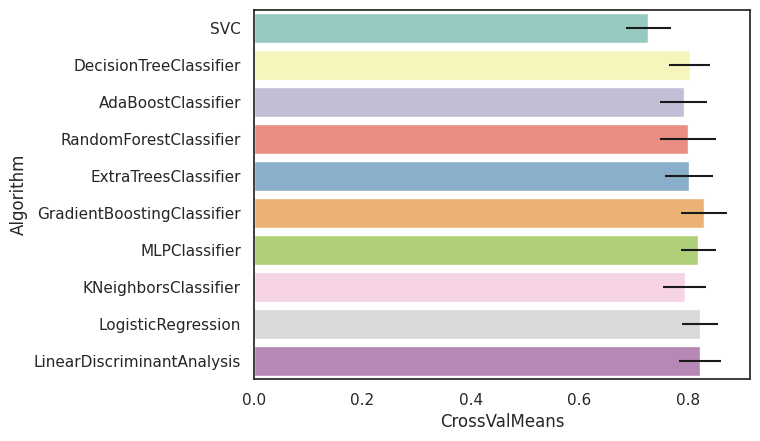

In [73]:
g = sns.barplot(x= "CrossValMeans",y= "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr':cv_std})

- I decided to choose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

##### 6.1.2 Hyperparameter tunning for best models

In [74]:
# Adaboost

DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid= ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of AdaBoostClassifier is deprecated in favor of 'estimator'. See AdaBoostClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


In [75]:
gsadaDTC.best_score_

0.8275536261491316

In [76]:
# ExtraTrees

ExtC = ExtraTreesClassifier()


ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid= ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


In [77]:
gsExtC.best_score_

0.8319969356486212

In [80]:
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308861082737489

In [84]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1]
              }

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:280: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


0.8308861082737486

In [85]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

#### 6.1.3 Plot learning curves
- Learning curves are a good way to see the overfitting effect on the training set and the effect of the training size on the accuracy.

In [86]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

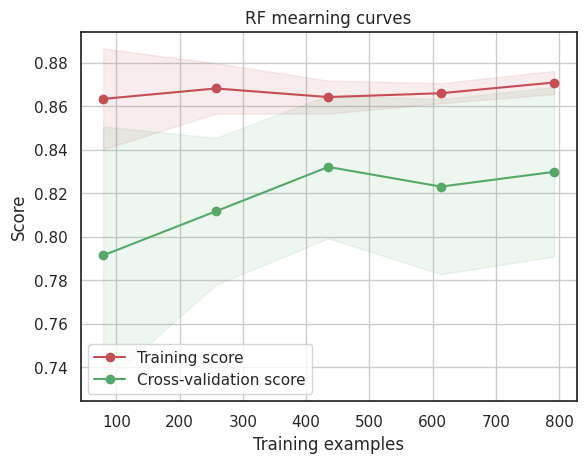

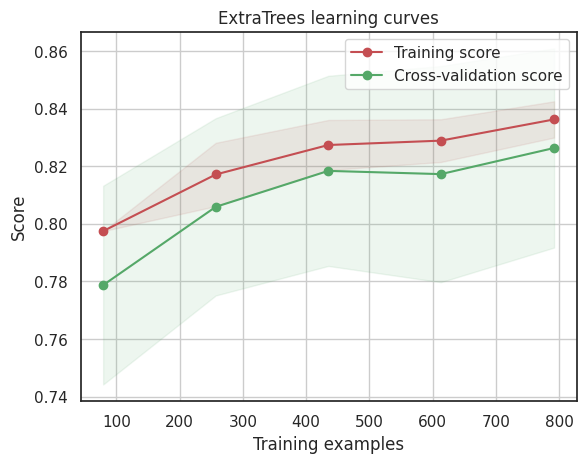

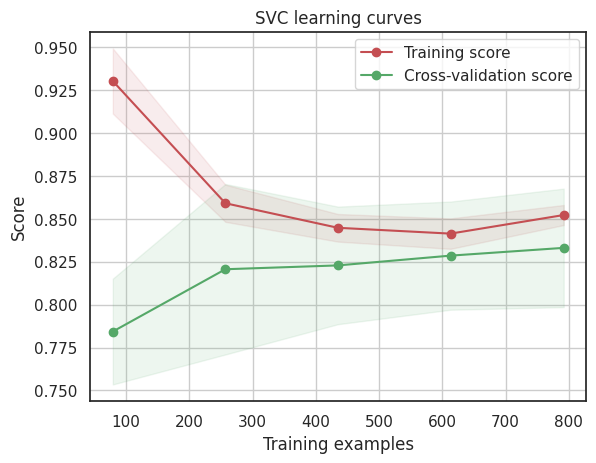

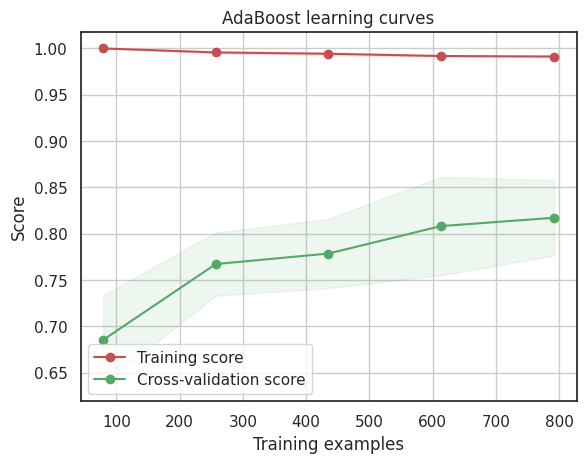

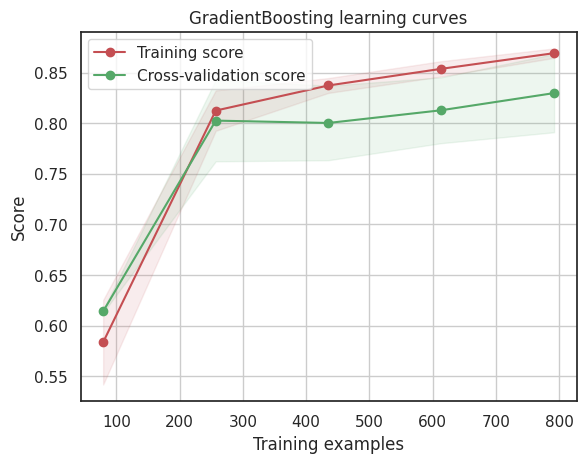

In [87]:
g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

#### 6.1.4  Feature importance of tree based classifiers
- In order to see the most informative features for the prediction of passengers survival, i displayed the feature importance for the 4 tree based classifiers.

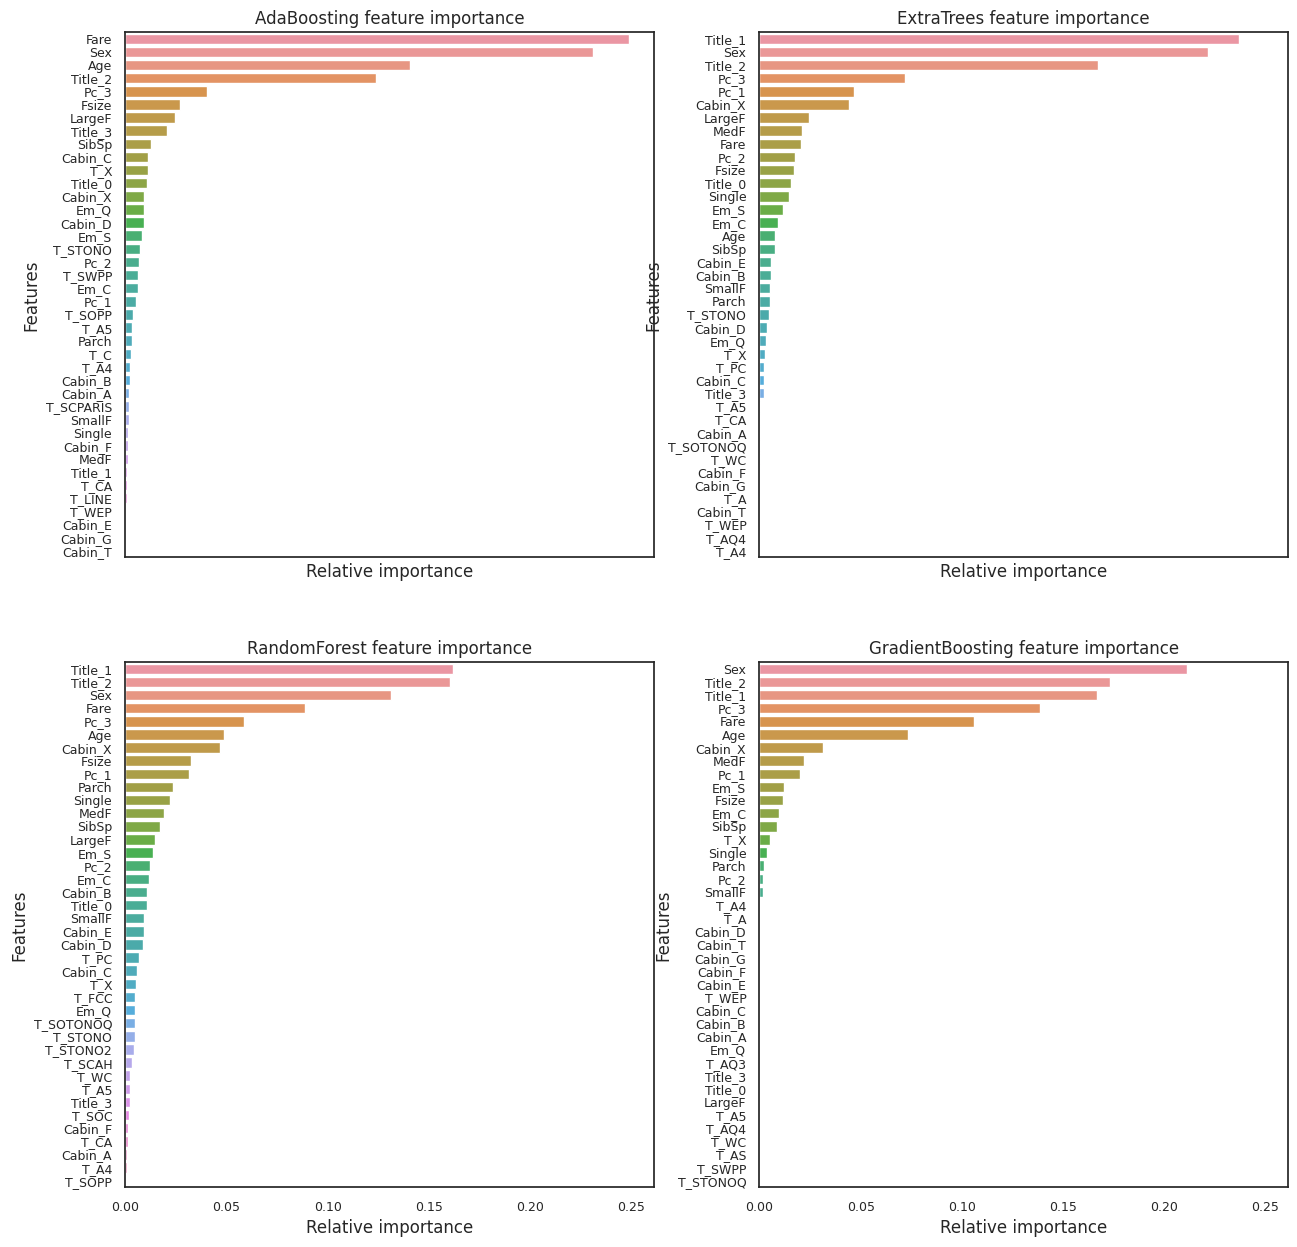

In [88]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

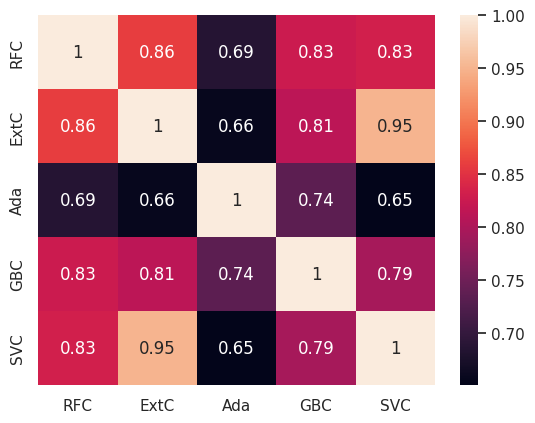

In [89]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

### 6.2 Ensemble modeling

#### 6.2.1 Combining models
- I choosed a voting classifier to combine the predictions coming from the 5 classifiers.

- I preferred to pass the argument "soft" to the voting parameter to take into account the probability of each vote.

In [90]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

### 6.3 Prediction

In [91]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("ensemble_python_voting.csv",index=False)